In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import accuracy_score

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.19.0
GPU Available: []


In [2]:
PROCESSED_DIR = Path(r"C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\data\processed\faces")
MODELS_DIR = Path(r"C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR = Path(r"C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

BATCH_SIZE = 32
EPOCHS = 20
IMG_SIZE = (160, 160)

print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Image size: {IMG_SIZE}")


Batch size: 32
Epochs: 20
Image size: (160, 160)


## Load Preprocessed Data

In [3]:
print("Loading preprocessed data...")

X_train = np.load(PROCESSED_DIR / 'X_train.npy')
y_train = np.load(PROCESSED_DIR / 'y_train.npy')
X_val = np.load(PROCESSED_DIR / 'X_val.npy')
y_val = np.load(PROCESSED_DIR / 'y_val.npy')
X_test = np.load(PROCESSED_DIR / 'X_test.npy')
y_test = np.load(PROCESSED_DIR / 'y_test.npy')

with open(PROCESSED_DIR / 'label_mapping.pkl', 'rb') as f:
    label_mapping = pickle.load(f)

num_classes = label_mapping['num_classes']
id_to_person = label_mapping['id_to_person']

print(f"\n=== DATA LOADED ===")
print(f"X_train: {X_train.shape}")
print(f"X_val:   {X_val.shape}")
print(f"X_test:  {X_test.shape}")
print(f"\nNumber of identities: {num_classes}")
print(f"Value range: [{X_train.min():.2f}, {X_train.max():.2f}]")


Loading preprocessed data...

=== DATA LOADED ===
X_train: (2906, 160, 160, 3)
X_val:   (700, 160, 160, 3)
X_test:  (718, 160, 160, 3)

Number of identities: 158
Value range: [-1.00, 1.00]


In [4]:
X_train_scaled = (X_train + 1) / 2
X_val_scaled = (X_val + 1) / 2
X_test_scaled = (X_test + 1) / 2

print(f"Data rescaled to [0, 1] for MobileNetV2")
print(f"New range: [{X_train_scaled.min():.2f}, {X_train_scaled.max():.2f}]")


Data rescaled to [0, 1] for MobileNetV2
New range: [0.00, 1.00]


## Building Face Recognition Model

In [5]:
def build_face_recognition_model(input_shape=(160, 160, 3), num_classes=100):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet', pooling='avg')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model, base_model

model, base_model = build_face_recognition_model(input_shape=(160, 160, 3), num_classes=num_classes)
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 158)            │        40,606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,088,862 (11.78 MB)

 Trainable params: 829,342 (3.16 MB)

 Non-trainable params: 2,259,520 (8.62 MB)

In [6]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")


Model compiled successfully!


In [7]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint(str(MODELS_DIR / 'face_recognition_best.h5'), monitor='val_accuracy', save_best_only=True, verbose=1)
]

print("Callbacks configured!")


Callbacks configured!


## Training

In [9]:
print(" Training classification head (frozen base) ===")
print(f"Trainable parameters: {sum([np.prod(v.shape) for v in model.trainable_weights]):,}\n")

history_phase1 = model.fit(
    X_train_scaled, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS // 2,
    validation_data=(X_val_scaled, y_val),
    callbacks=callbacks,
    verbose=0
)



 Training classification head (frozen base) ===
Trainable parameters: 829,342


Epoch 1: val_accuracy improved from 0.16857 to 0.35571, saving model to C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\models\face_recognition_best.h5



Epoch 2: val_accuracy improved from 0.35571 to 0.40714, saving model to C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\models\face_recognition_best.h5



Epoch 3: val_accuracy improved from 0.40714 to 0.45286, saving model to C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\models\face_recognition_best.h5



Epoch 4: val_accuracy improved from 0.45286 to 0.46429, saving model to C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\models\face_recognition_best.h5



Epoch 5: val_accuracy improved from 0.46429 to 0.47143, saving model to C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\models\face_recognition_best.h5



Epoch 6: val_accuracy improved from 0.47143 to 0.51714, saving model to C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\models\face_recognition_best.h5



Epoch 7: val_accuracy did not improve from 0.51714

Epoch 8: val_accuracy did not improve from 0.51714

Epoch 9: val_accuracy improved from 0.51714 to 0.54000, saving model to C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\models\face_recognition_best.h5



Epoch 10: val_accuracy improved from 0.54000 to 0.55286, saving model to C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\models\face_recognition_best.h5


Restoring model weights from the end of the best epoch: 9.


In [11]:
print("\n Fine-tuning (unfreezing top layers) ===")

base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

trainable_params = sum([np.prod(v.shape) for v in model.trainable_weights])
print(f"Trainable parameters: {trainable_params:,}\n")

history_phase2 = model.fit(
    X_train_scaled, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS // 2,
    validation_data=(X_val_scaled, y_val),
    callbacks=callbacks,
    verbose=0
)




 Fine-tuning (unfreezing top layers) ===
Trainable parameters: 2,355,422


Epoch 1: val_accuracy did not improve from 0.55286

Epoch 2: val_accuracy did not improve from 0.55286

Epoch 3: val_accuracy did not improve from 0.55286

Epoch 4: val_accuracy did not improve from 0.55286

Epoch 5: val_accuracy did not improve from 0.55286

Epoch 6: val_accuracy did not improve from 0.55286

Epoch 7: val_accuracy did not improve from 0.55286

Epoch 8: val_accuracy did not improve from 0.55286

Epoch 9: val_accuracy did not improve from 0.55286

Epoch 10: val_accuracy did not improve from 0.55286
Restoring model weights from the end of the best epoch: 10.


## Visualization

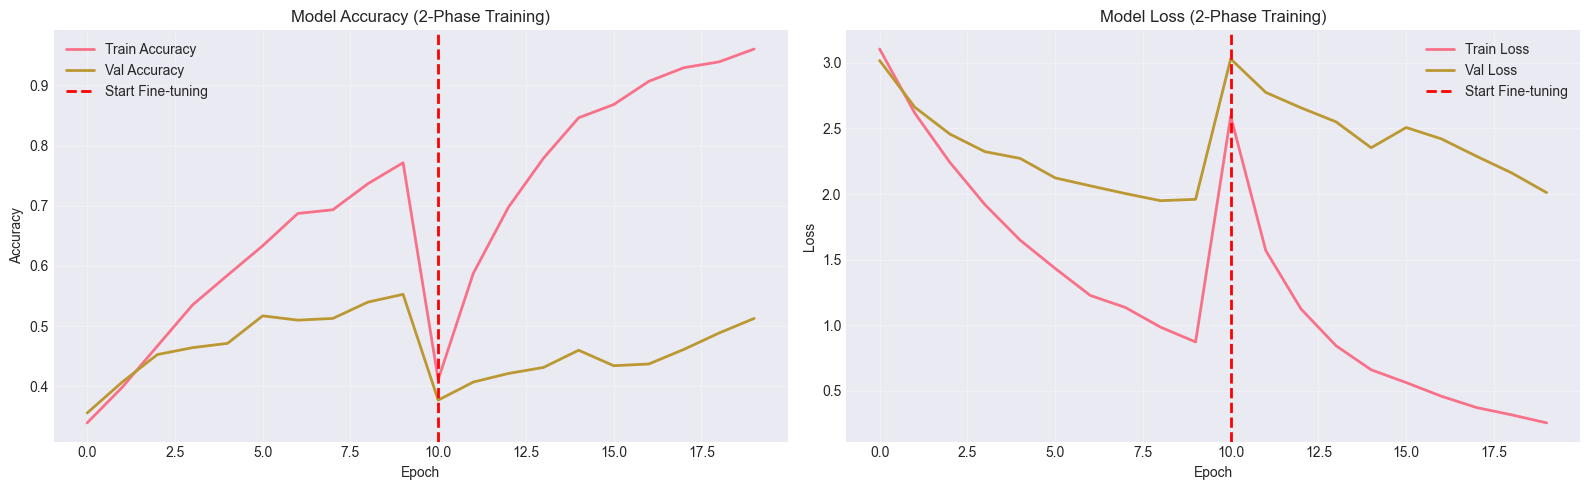


Best Validation Accuracy: 0.5529 (Epoch 10)


In [12]:
history_combined = {
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss']
}

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
phase1_epochs = len(history_phase1.history['accuracy'])

# Accuracy
axes[0].plot(history_combined['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history_combined['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].axvline(x=phase1_epochs, color='red', linestyle='--', linewidth=2, label='Start Fine-tuning')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy (2-Phase Training)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Loss
axes[1].plot(history_combined['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history_combined['val_loss'], label='Val Loss', linewidth=2)
axes[1].axvline(x=phase1_epochs, color='red', linestyle='--', linewidth=2, label='Start Fine-tuning')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss (2-Phase Training)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

best_val_acc = max(history_combined['val_accuracy'])
best_epoch = history_combined['val_accuracy'].index(best_val_acc) + 1
print(f"\nBest Validation Accuracy: {best_val_acc:.4f} (Epoch {best_epoch})")


## Evaluate on Test Data

In [13]:
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"=== TEST SET RESULTS ===")
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

y_pred_probs = model.predict(X_test_scaled, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

top5_acc = tf.keras.metrics.sparse_top_k_categorical_accuracy(
    y_test, y_pred_probs, k=5
).numpy().mean()

print(f"Top-5 Accuracy: {top5_acc:.4f} ({top5_acc*100:.2f}%)")


=== TEST SET RESULTS ===
Test Loss:     1.9501
Test Accuracy: 0.5209 (52.09%)
Top-5 Accuracy: 0.7813 (78.13%)


## Per-Identity


=== PER-IDENTITY STATISTICS ===
Mean accuracy: 0.3561
Median accuracy: 0.3333
Std deviation: 0.3288
Min accuracy: 0.0000
Max accuracy: 1.0000


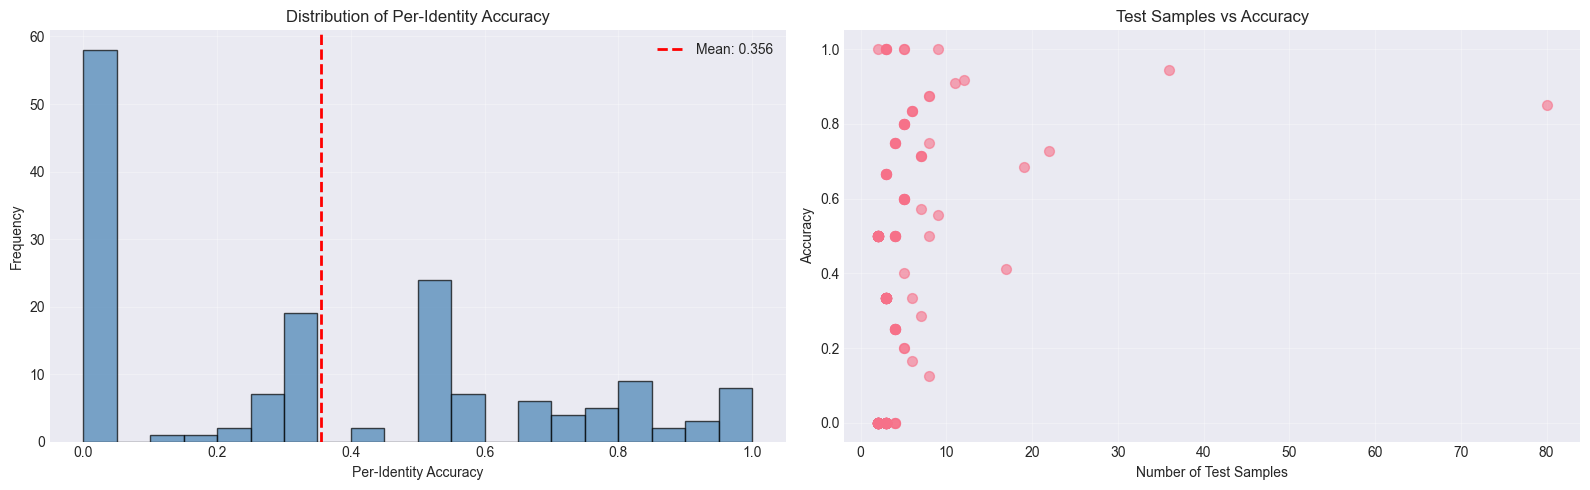

In [14]:
unique_ids = np.unique(y_test)
per_identity_acc = []
per_identity_count = []

for person_id in unique_ids:
    mask = y_test == person_id
    acc = accuracy_score(y_test[mask], y_pred[mask])
    count = mask.sum()
    per_identity_acc.append(acc)
    per_identity_count.append(count)

print(f"\n=== PER-IDENTITY STATISTICS ===")
print(f"Mean accuracy: {np.mean(per_identity_acc):.4f}")
print(f"Median accuracy: {np.median(per_identity_acc):.4f}")
print(f"Std deviation: {np.std(per_identity_acc):.4f}")
print(f"Min accuracy: {np.min(per_identity_acc):.4f}")
print(f"Max accuracy: {np.max(per_identity_acc):.4f}")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].hist(per_identity_acc, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(per_identity_acc), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {np.mean(per_identity_acc):.3f}')
axes[0].set_xlabel('Per-Identity Accuracy')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Per-Identity Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].scatter(per_identity_count, per_identity_acc, alpha=0.6, s=50)
axes[1].set_xlabel('Number of Test Samples')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Test Samples vs Accuracy')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Sample Prediction

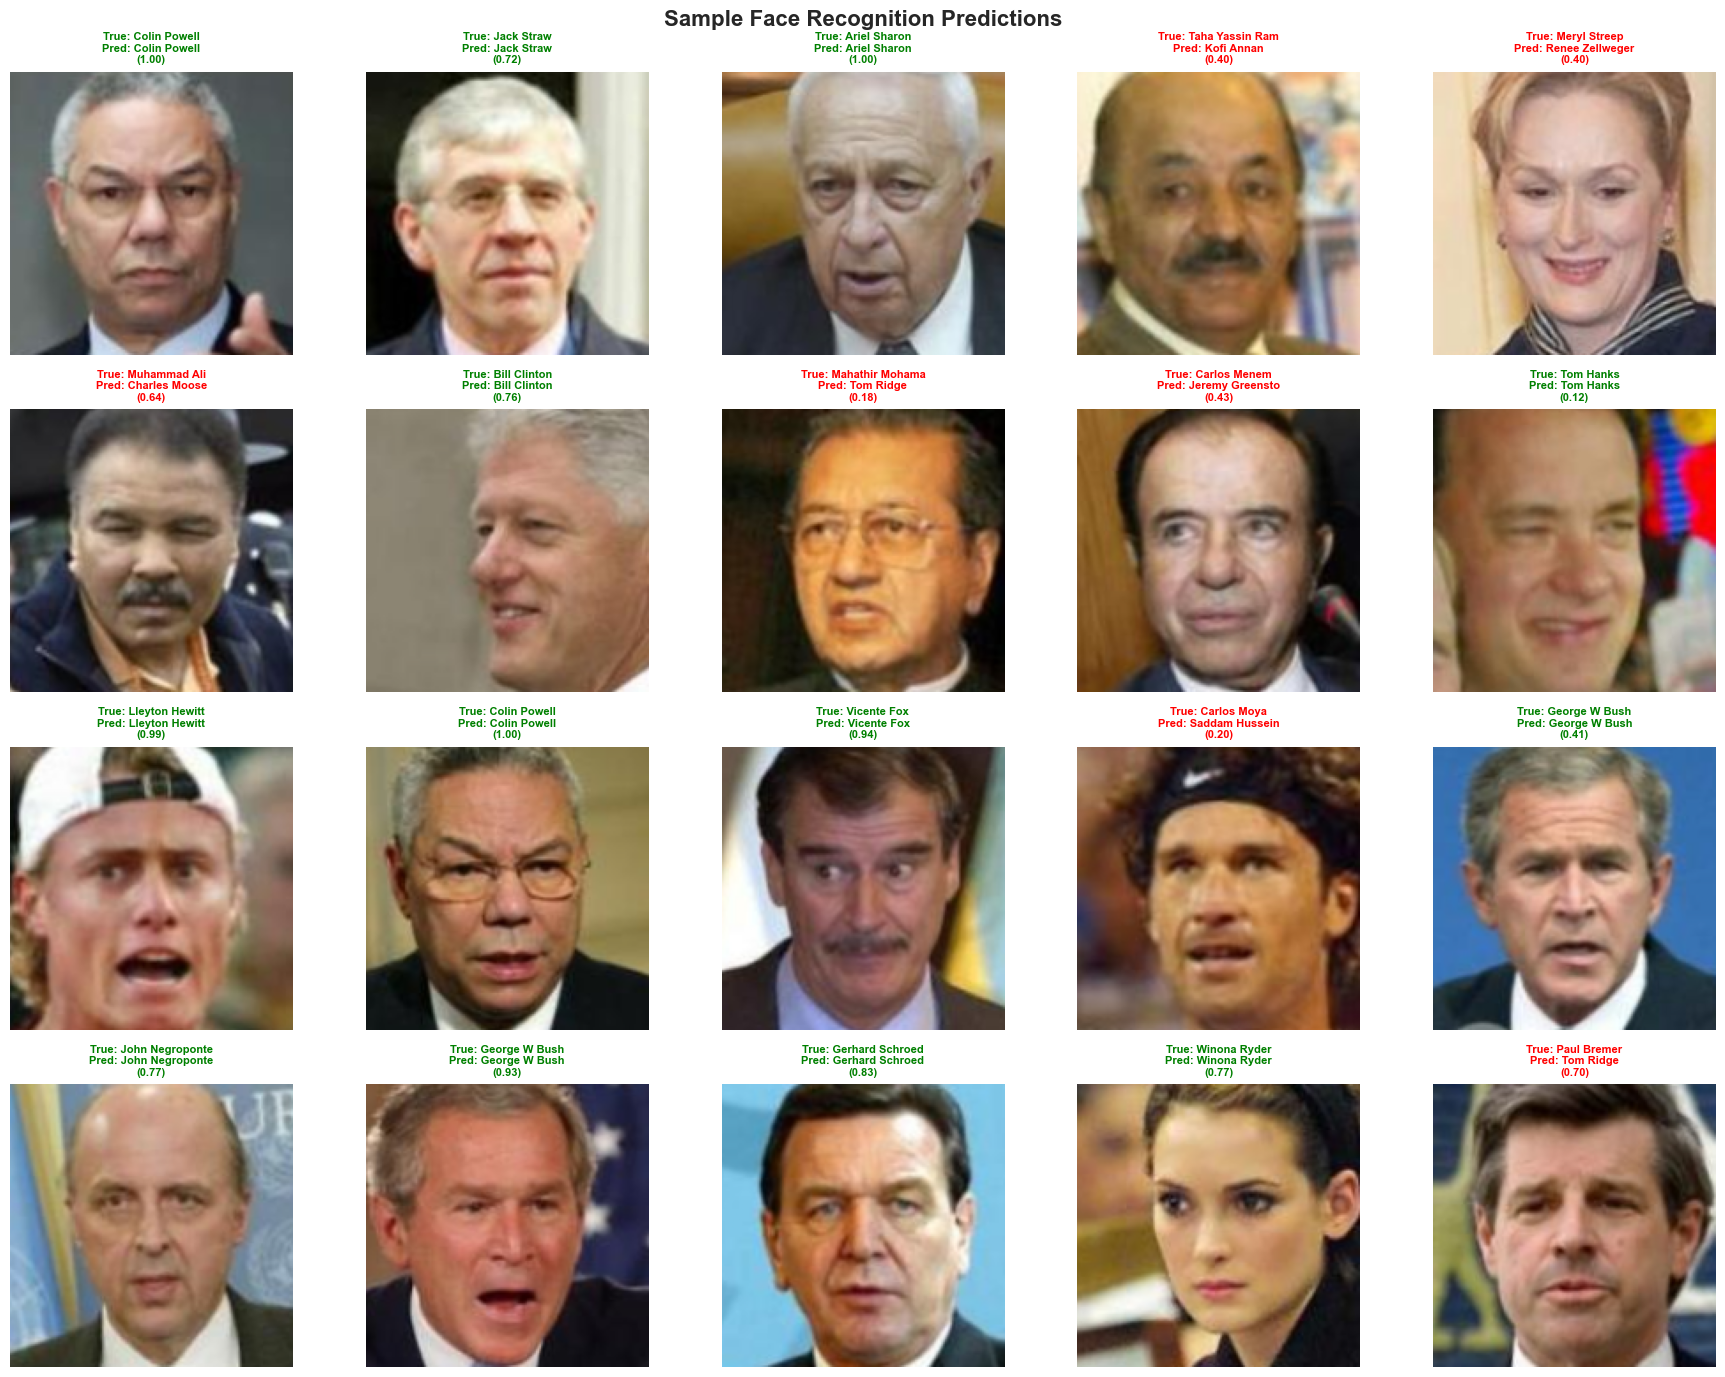

In [15]:
n_samples = 20
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)

fig, axes = plt.subplots(4, 5, figsize=(18, 14))
fig.suptitle('Sample Face Recognition Predictions', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, sample_idx in enumerate(sample_indices):
    img = (X_test[sample_idx] + 1) / 2
    true_label = y_test[sample_idx]
    pred_label = y_pred[sample_idx]
    pred_prob = y_pred_probs[sample_idx][pred_label]

    true_name = id_to_person[true_label].replace('_', ' ')
    pred_name = id_to_person[pred_label].replace('_', ' ')

    axes[idx].imshow(img)
    color = 'green' if true_label == pred_label else 'red'
    title = f'True: {true_name[:15]}\nPred: {pred_name[:15]}\n({pred_prob:.2f})'
    axes[idx].set_title(title, fontsize=8, color=color, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()
